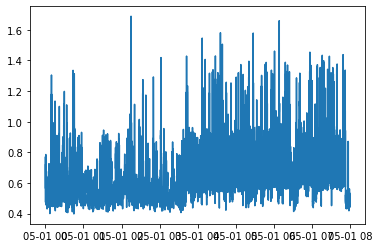

In [25]:
import sqlite3 as db
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import sqlite3 as db
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
database = "/home/sachin/Downloads/RWO_0004_Ventilatoren_00.sqlite"

con = db.connect(database)
df = pd.read_sql_query(f"SELECT time, value FROM Value WHERE sensor_id=2 AND "
                       f"time >= '{1619820000000}' AND time < '{1619848800000}'",
                       con)
df["time"] = df["time"].apply(lambda utc: datetime.fromtimestamp(int(utc / 1000)))
df.drop_duplicates(subset="time", keep="first", inplace=True)
df.index = df['time']
df = df.reindex(pd.date_range(min(df.index),
                              max(df.index),
                              freq='S'))
df.drop('time', axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
# df = df.interpolate().fillna(method='bfill')
con.close()
plt.plot(df)
plt.show()

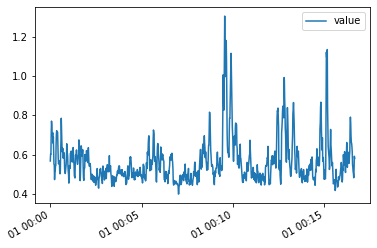

In [26]:
vibration = df.iloc[:1000]
vibration.plot()

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train = vibration.iloc[:-60]
test = vibration.iloc[-60:]
scaler = StandardScaler()
train['train'] = scaler.fit_transform(train)
test['test'] = scaler.transform(test)

/home/sachin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/sachin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
import numpy as np

train_data = train.values
test_data = test.values

timesteps = 10


train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]


In [29]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', gamma=1, C=1000, epsilon = 0.0001)


[0.468158, 0.468923, 0.461336, 0.436449, 0.442287, 0.450362, 0.48815, 0.480794, 0.472897]


Text(0, 0.5, 'Acceleration: X-axis (g)')

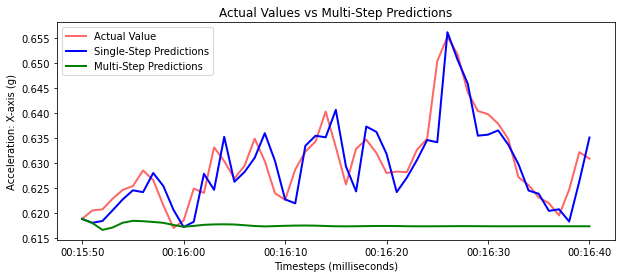

In [30]:
model.fit(x_train, y_train[:,0])

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

multi_step = [x[0] for x in test_data[:9]]
print(multi_step)
for i in range(0, len(y_test_pred)):
    pred_i = model.predict([multi_step[-9:]])
    # pred_i = model.predict([[y_mov_test[-9], y_mov_test[-8], y_mov_test[-7], y_mov_test[-6], y_mov_test[-5],
    #                          y_mov_test[-4], y_mov_test[-3], y_mov_test[-2], y_mov_test[-1]]]).reshape(-1, 1)
    multi_step.append(pred_i[0])
multi_step = multi_step[-len(y_test_pred):]


y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
multi_step = scaler.inverse_transform(multi_step)

train_timestamps = list(train.index)[timesteps-1:]
test_timestamps = list(test.index)[timesteps-1:]


plt.figure(figsize=(10,4))
plt.plot(test_timestamps, y_test, color='red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color='blue', linewidth=2.0)
plt.plot(test_timestamps, multi_step, color='green', linewidth=2.0)
#plt.legend(['Actual Value', 'Multi-Step Predictions'], loc="upper right")
plt.legend(['Actual Value', 'Single-Step Predictions', 'Multi-Step Predictions'])
plt.title("Actual Values vs Multi-Step Predictions")
plt.xlabel('Timesteps (milliseconds)')
plt.ylabel('Acceleration: X-axis (g)')